과소적합(underfitting)
- 모델이 너무 단순하거나, 규제가 너무 많거나, 충분한 훈련을 하지 않은 경우 발생
- 네트워크가 훈련 세트에서 적절한 패턴을 학습하지 못했다는 의미
- 그러나 너무 오래 훈련하면 모델이 과대적합(overfitting)되어 테스트 데이터에 일반화되지 않는 훈련 데이터로부터 패턴을 학습하게 된다.

1. 적절한 epoch 수로 훈련
2. 완전한 훈련 데이터 사용: 모델이 처리할 것으로 예상되는 전체 입력 범위를 포괄하는 것이 좋다.
3. 정규화: 모델이 저장할 수 있는 정보의 양과 유형에 제약을 가하여, 적은 수의 패턴만 기억하게 만들어 일반화 가능성이 더 높은 패턴을 중점으로 최적화하게 한다.


In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.16.1


In [2]:
%pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to c:\users\git\appdata\local\temp\pip-req-build-s0ptln1f
  Resolved https://github.com/tensorflow/docs to commit ec3a1b3f9a604c6cd26c7537f2b9fd270a3eedbf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=183879 sha256=c922b72e0141e988b2a367f6145b31005ac39d808465b57a1ad930d484e43713
  Stored in directory: C:\Users\GIT\AppData\Local\Temp\pip-ephem-wheel-cache-ua38arcb\wheels\34\53\89\3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\GIT\AppData\Local\Temp\pip-req-build-s0ptln1f'


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
# 힉스(Higgs) 데이터세트, 28개의 특성과, 이진 클래스 레이블이 있는 11,000,000개

gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 4019s 1us/step


힉스 데이터 세트
- 28개의 특성(Features)
- 이진 클래스 레이블(Binary Class Labels): 데이터 포인트에 대한 목표 변수
- 데이터 구조: 11,000,000 x 28 크기의 행렬 (데이터 포인트 x 특성)
- 대규모 데이터셋의 경우 전처리 과정이 필요할 수있다.
    - 데이터의 결측치 처리
    - 이상치 제거
    - 특성 스케일링
    - 범주형 변수의 인코딩

In [6]:
FEATURES = 28

In [7]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label  # feature_vector, label 쌍으로 다시 압축

In [9]:
# 대규모 데이터 배치에서 작업
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


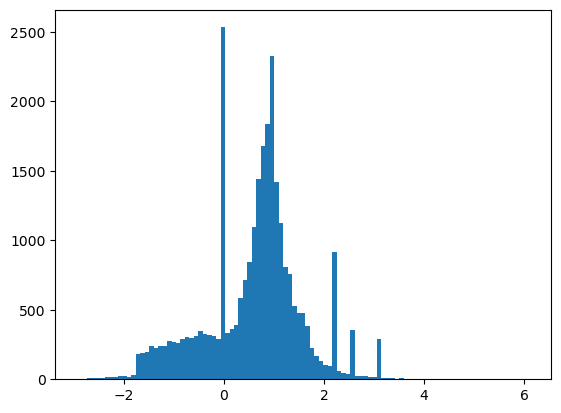

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
N_VALIDATION = int(1e3) # 1000
N_TRAIN = int(1e4)      # 10000
BUFFER_SIZE = int(1e4)  # 데이터셋을 셔플링할 때 사용되는 버퍼의 크기
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
# 로더가 각 epoch 에서 파일 데이터를 다시 로딩할 필요 없도록 캐싱
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

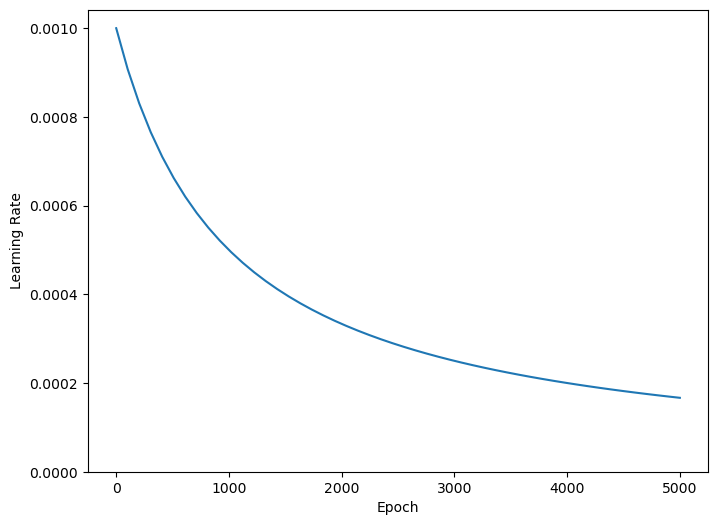

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [18]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [20]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

z:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4866,  binary_crossentropy:0.7734,  loss:0.7734,  val_accuracy:0.4700,  val_binary_crossentropy:0.5033,  val_loss:0.5033,  
...

z:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


.................................................................................................
Epoch: 100, accuracy:0.5993,  binary_crossentropy:0.6251,  loss:0.6251,  val_accuracy:0.5890,  val_binary_crossentropy:0.4171,  val_loss:0.4171,  
....................................................................................................
Epoch: 200, accuracy:0.6226,  binary_crossentropy:0.6108,  loss:0.6108,  val_accuracy:0.5990,  val_binary_crossentropy:0.4102,  val_loss:0.4102,  
....................................................................................................
Epoch: 300, accuracy:0.6492,  binary_crossentropy:0.6003,  loss:0.6003,  val_accuracy:0.6140,  val_binary_crossentropy:0.4021,  val_loss:0.4021,  
....................................................................................................
Epoch: 400, accuracy:0.6596,  binary_crossentropy:0.5921,  loss:0.5921,  val_accuracy:0.6380,  val_binary_crossentropy:0.3971,  val_loss:0.3971,  
...........

(0.5, 0.7)

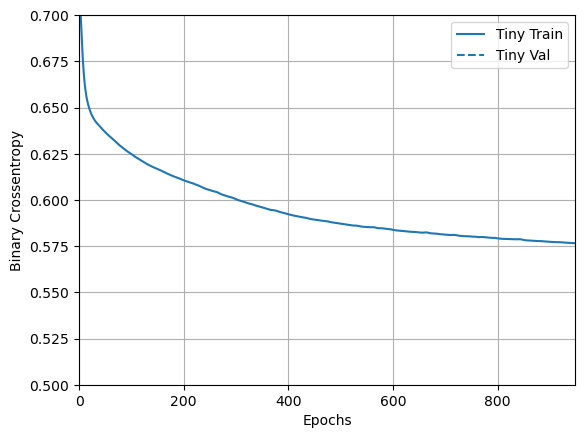

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [24]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4769,  binary_crossentropy:0.7268,  loss:0.7268,  val_accuracy:0.4690,  val_binary_crossentropy:0.4699,  val_loss:0.4699,  
....................................................................................................
Epoch: 100, accuracy:0.6367,  binary_crossentropy:0.6085,  loss:0.6085,  val_accuracy:0.6080,  val_binary_crossentropy:0.4113,  val_loss:0.4113,  
....................................................................................................
Epoch: 200, accuracy:0.6622,  binary_crossentropy:0.5873,  loss:0.5873,  val_accuracy:0.6700,  val_binary_crossentropy:0.3986,  val_loss:0.3986,  
....................................................................................................
Epoch: 300, accuracy:0.6791,  binary_crossentropy:0.5746,  loss:0.5746,  val_accuracy:0.6520,  val_binary_crossentropy:0.3920,  val_loss:0.3920,  
....................................................................................................
Epoch: 40

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4912,  binary_crossentropy:0.6922,  loss:0.6922,  val_accuracy:0.4870,  val_binary_crossentropy:0.4504,  val_loss:0.4504,  
....................................................................................................
Epoch: 100, accuracy:0.7102,  binary_crossentropy:0.5353,  loss:0.5353,  val_accuracy:0.6350,  val_binary_crossentropy:0.4120,  val_loss:0.4120,  
....................................................................................................
Epoch: 200, accuracy:0.7892,  binary_crossentropy:0.4266,  loss:0.4266,  val_accuracy:0.6470,  val_binary_crossentropy:0.4618,  val_loss:0.4618,  
........................................................

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4933,  binary_crossentropy:0.8496,  loss:0.8496,  val_accuracy:0.5470,  val_binary_crossentropy:0.4503,  val_loss:0.4503,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6730,  val_binary_crossentropy:1.1708,  val_loss:1.1708,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6660,  val_binary_crossentropy:1.6129,  val_loss:1.6129,  
.........................

Text(0.5, 0, 'Epochs [Log Scale]')

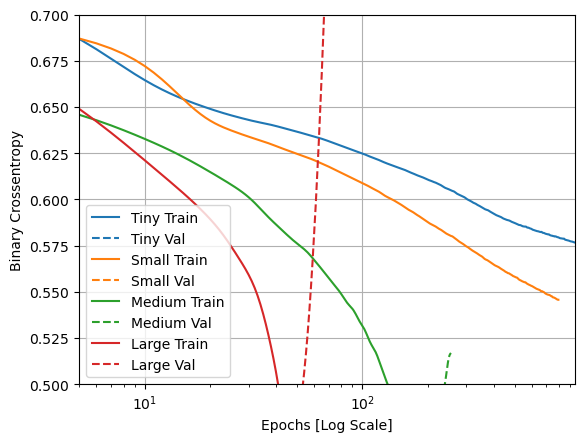

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [32]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

Launching TensorBoard...

KeyboardInterrupt: 

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [ ]:
# tensorboard dev upload --logdir  {logdir}/sizes

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/GIT/AppData/Local/Temp/tmpc06nphvz/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5087,  binary_crossentropy:0.8080,  loss:2.3276,  val_accuracy:0.4740,  val_binary_crossentropy:0.4611,  val_loss:1.4195,  
....................................................................................................
Epoch: 100, accuracy:0.6555,  binary_crossentropy:0.5999,  loss:0.6227,  val_accuracy:0.6320,  val_binary_crossentropy:0.3925,  val_loss:0.4075,  
....................................................................................................
Epoch: 200, accuracy:0.6760,  binary_crossentropy:0.5820,  loss:0.6038,  val_accuracy:0.6760,  val_binary_crossentropy:0.3866,  val_loss:0.4011,  
....................................................................................................
Epoch: 300, accuracy:0.6822,  binary_crossentropy:0.5752,  loss:0.5973,  val_accuracy:0.6900,  val_binary_crossentropy:0.3900,  val_loss:0.4048,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

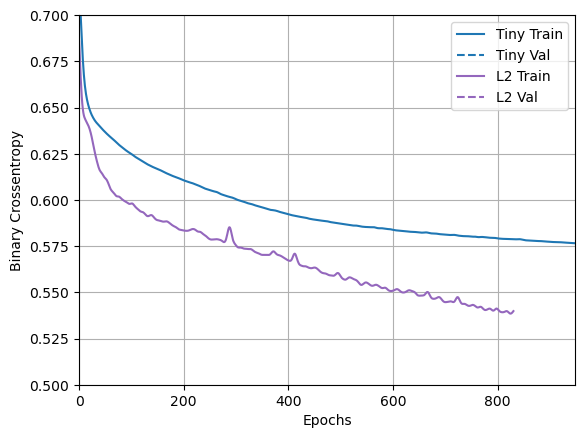

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5043,  binary_crossentropy:0.7914,  loss:0.7914,  val_accuracy:0.5520,  val_binary_crossentropy:0.4599,  val_loss:0.4599,  
....................................................................................................
Epoch: 100, accuracy:0.6563,  binary_crossentropy:0.5932,  loss:0.5932,  val_accuracy:0.6680,  val_binary_crossentropy:0.3819,  val_loss:0.3819,  
....................................................................................................
Epoch: 200, accuracy:0.6912,  binary_crossentropy:0.5565,  loss:0.5565,  val_accuracy:0.6560,  val_binary_crossentropy:0.3865,  val_loss:0.3865,  
....................................................................................................
Epoch: 300, accuracy:0.7151,  binary_crossentropy:0.5121,  loss:0.5121,  val_accuracy:0.6970,  val_binary_crossentropy:0.3991,  val_loss:0.3991,  
..........................................................

(0.5, 0.7)

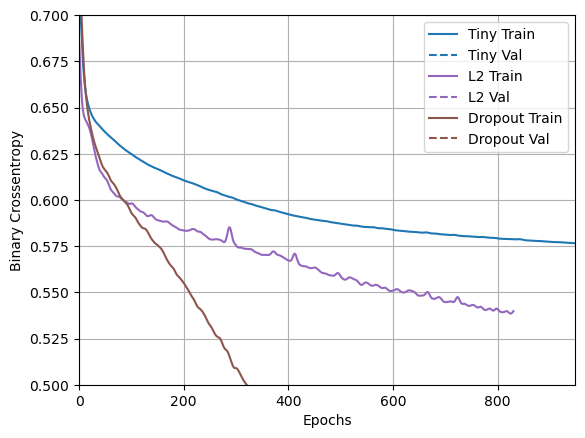

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5072,  binary_crossentropy:0.7874,  loss:0.9458,  val_accuracy:0.5550,  val_binary_crossentropy:0.4578,  val_loss:0.5629,  
....................................................................................................
Epoch: 100, accuracy:0.6454,  binary_crossentropy:0.6036,  loss:0.6329,  val_accuracy:0.6240,  val_binary_crossentropy:0.3945,  val_loss:0.4140,  
....................................................................................................
Epoch: 200, accuracy:0.6586,  binary_crossentropy:0.5907,  loss:0.6162,  val_accuracy:0.6840,  val_binary_crossentropy:0.3810,  val_loss:0.3981,  
....................................................................................................
Epoch: 300, accuracy:0.6748,  binary_crossentropy:0.5862,  loss:0.6141,  val_accuracy:0.6660,  val_binary_crossentropy:0.3842,  val_loss:0.4028,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

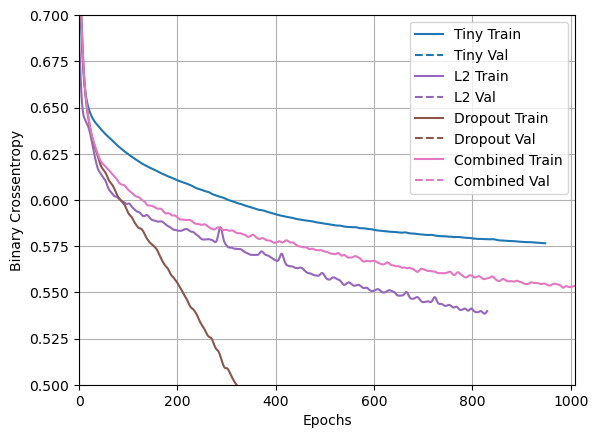

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
# %tensorboard --logdir {logdir}/regularizers

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
#     width = "100%",
#     height="800px")

In [ ]:
# tensorboard dev upload --logdir  {logdir}/regularizers

### 과대적합을 방지하는 일반적인 방법

- 더 많은 훈련 데이터
- 네트워크 용량을 줄임
- 가중치 정규화 추가
- 드롭아웃 추가

1. 데이터 증강
2. 배치 정규화(tf.keras.layers.BatchNormalization)

각 방법은 그 자체로 도움이 될 수 있지만 이를 결합하여 더 큰 효과를 거둘 수 있는 경우가 종종 있다는 점을 기억하기